# 02 - Testes Inferenciais e Intervalos de Confiança

Este notebook aplica testes estatísticos para validar as hipóteses levantadas na análise exploratória (EDA).

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

# Carregar dados limpos
base_path = "datasets/cleaned/"
files = {
    "acidentes": f"{base_path}Acidentes_DadosAbertos_20250912.parquet",
    "localidades": f"{base_path}Localidade_DadosAbertos_20250912.parquet",
    "veiculos": f"{base_path}TipoVeiculo_DadosAbertos_20250912.parquet",
    "vitimas": f"{base_path}Vitimas_DadosAbertos_20250912.parquet"
}

print("CARREGANDO DADOS PARA TESTES INFERENCIAIS")
print("="*55)
dfs = {name: pd.read_parquet(path) for name, path in files.items()}

for name, df in dfs.items():
    print(f"{name.upper()} → {df.shape[0]:,} linhas | {df.shape[1]} colunas")

CARREGANDO DADOS PARA TESTES INFERENCIAIS
ACIDENTES → 1,673,564 linhas | 37 colunas
LOCALIDADES → 498,133 linhas | 12 colunas
VEICULOS → 6,860,268 linhas | 4 colunas
VITIMAS → 8,028,049 linhas | 18 colunas


## Teste 1: Bootstrap - Motocicletas vs Automóveis

**H₀:** p_moto = p_auto (proporções de acidentes com óbito são iguais)  
**H₁:** p_moto ≠ p_auto (proporções são diferentes)  

**Método:** 
- **Bootstrap** (reamostragem com reposição) para estimar IC95% da diferença de proporções


 TESTE 1: Motocicletas vs Automóveis - Bootstrap
Veículos após filtro e amostra: 60,392
Vítimas correspondentes: 69,406
Registros finais para análise: 69,514
   Motocicletas: 17,688
   Automóveis: 51,826

 PROPORÇÕES OBSERVADAS:
  Motocicletas: 0.0176 (1.76%)
  Automóveis: 0.0059 (0.59%)
  Diferença observada: 0.0117

 Executando 10,000 iterações de Bootstrap...

 RESULTADOS DO BOOTSTRAP:
  Diferença média (bootstrap): 0.0117
  Erro padrão (bootstrap): 0.0010
  IC95% (percentil): [0.0096, 0.0137]

 INTERPRETAÇÃO (α = 0.05):
  IC95% não contém 0 → DIFERENÇA SIGNIFICATIVA
  Há evidência de que as proporções são diferentes
  Motocicletas têm proporção +196.8% maior de acidentes com óbito


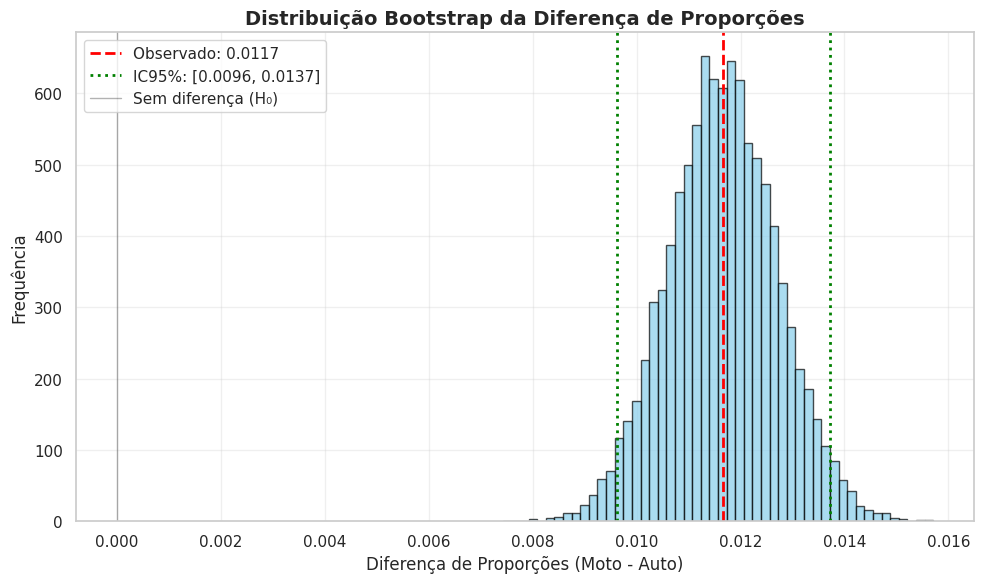


 TÉCNICA DE REAMOSTRAGEM UTILIZADA:
  BOOTSTRAP (reamostragem com reposição) → Intervalo de confiança 95%
  Método não-paramétrico → Não assume distribuição normal
  Interpretação: Se IC95% não contém 0, há diferença significativa


In [7]:
print(" TESTE 1: Motocicletas vs Automóveis - Bootstrap")
print("="*75)

df_veic = dfs["veiculos"]
df_vit = dfs["vitimas"]

df_veic_filtered = df_veic[df_veic['tipo_veiculo'].isin(['MOTOCICLETA', 'AUTOMOVEL'])].copy()

sample_size = 0.01
df_veic_sample = df_veic_filtered.sample(frac=sample_size, random_state=42)

print(f"Veículos após filtro e amostra: {len(df_veic_sample):,}")

acidentes_sample = df_veic_sample['num_acidente'].unique()
df_vit_sample = df_vit[df_vit['num_acidente'].isin(acidentes_sample)]

print(f"Vítimas correspondentes: {len(df_vit_sample):,}")

df_moto_auto = df_veic_sample.merge(df_vit_sample, on="num_acidente", how="inner")
df_moto_auto['tem_obito'] = (df_moto_auto['qtde_obitos'] > 0).astype(int)

print(f"Registros finais para análise: {len(df_moto_auto):,}")

moto_data = df_moto_auto[df_moto_auto['tipo_veiculo'] == 'MOTOCICLETA']['tem_obito'].values
auto_data = df_moto_auto[df_moto_auto['tipo_veiculo'] == 'AUTOMOVEL']['tem_obito'].values

print(f"   Motocicletas: {len(moto_data):,}")
print(f"   Automóveis: {len(auto_data):,}")

p_moto_obs = np.mean(moto_data)
p_auto_obs = np.mean(auto_data)
diff_obs = p_moto_obs - p_auto_obs

print(f"\n PROPORÇÕES OBSERVADAS:")
print(f"  Motocicletas: {p_moto_obs:.4f} ({p_moto_obs*100:.2f}%)")
print(f"  Automóveis: {p_auto_obs:.4f} ({p_auto_obs*100:.2f}%)")
print(f"  Diferença observada: {diff_obs:.4f}")

# ====================================
# BOOTSTRAP para Intervalo de Confiança
# ====================================
n_bootstrap = 10000
bootstrap_diffs = []

print(f"\n Executando {n_bootstrap:,} iterações de Bootstrap...")

np.random.seed(42)
for i in range(n_bootstrap):
    moto_resample = np.random.choice(moto_data, size=len(moto_data), replace=True)
    auto_resample = np.random.choice(auto_data, size=len(auto_data), replace=True)
    
    diff_boot = np.mean(moto_resample) - np.mean(auto_resample)
    bootstrap_diffs.append(diff_boot)

bootstrap_diffs = np.array(bootstrap_diffs)

# Intervalo de confiança 95% pelo método percentil
ic_lower = np.percentile(bootstrap_diffs, 2.5)
ic_upper = np.percentile(bootstrap_diffs, 97.5)

# Erro padrão bootstrap
se_bootstrap = np.std(bootstrap_diffs)

print(f"\n RESULTADOS DO BOOTSTRAP:")
print(f"  Diferença média (bootstrap): {np.mean(bootstrap_diffs):.4f}")
print(f"  Erro padrão (bootstrap): {se_bootstrap:.4f}")
print(f"  IC95% (percentil): [{ic_lower:.4f}, {ic_upper:.4f}]")

# Interpretação
alpha = 0.05
print(f"\n INTERPRETAÇÃO (α = {alpha}):")
if ic_lower > 0:
    print(f"  IC95% não contém 0 → DIFERENÇA SIGNIFICATIVA")
    print("  Há evidência de que as proporções são diferentes")
    print(f"  Motocicletas têm proporção {((p_moto_obs/p_auto_obs-1)*100):+.1f}% maior de acidentes com óbito")
elif ic_upper < 0:
    print(f"  IC95% não contém 0 → DIFERENÇA SIGNIFICATIVA")
    print("  Automóveis têm proporção maior de acidentes com óbito")
else:
    print(f"  IC95% contém 0 → Diferença não é estatisticamente significativa")
    print("  Não há evidência conclusiva de diferença entre as proporções")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(bootstrap_diffs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax.axvline(diff_obs, color='red', linestyle='--', linewidth=2, label=f'Observado: {diff_obs:.4f}')
ax.axvline(ic_lower, color='green', linestyle=':', linewidth=2, label=f'IC95%: [{ic_lower:.4f}, {ic_upper:.4f}]')
ax.axvline(ic_upper, color='green', linestyle=':', linewidth=2)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3, label='Sem diferença (H₀)')
ax.set_xlabel('Diferença de Proporções (Moto - Auto)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição Bootstrap da Diferença de Proporções', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n TÉCNICA DE REAMOSTRAGEM UTILIZADA:")
print("  BOOTSTRAP (reamostragem com reposição) → Intervalo de confiança 95%")
print("  Método não-paramétrico → Não assume distribuição normal")
print("  Interpretação: Se IC95% não contém 0, há diferença significativa")


## Teste 2: Bootstrap - Fim de Semana vs Dias Úteis

**H₀:** Período (fim de semana vs dias úteis) é independente da ocorrência de óbitos  
**H₁:** Há associação entre período e óbitos  

**Método:** Bootstrap para estimar IC95% da diferença de proporções

TESTE 2: Fim de Semana vs Dias Úteis - Bootstrap
 Amostra para teste: 16,736 registros (1% do total)

 PROPORÇÕES OBSERVADAS:
  Fins de semana: 0.0214 (2.14%) - n=4,818
  Dias úteis: 0.0154 (1.54%) - n=11,918
  Diferença observada: 0.0059

 Executando 10,000 iterações de Bootstrap...

 INTERVALO DE CONFIANÇA (BOOTSTRAP):
  IC95%: [0.0013, 0.0106]

 INTERPRETAÇÃO (α = 0.05):
  IC95% não contém 0 → DIFERENÇA SIGNIFICATIVA
  Há evidência de que as proporções são diferentes
  Fins de semana têm +38.5% MAIS acidentes com óbito


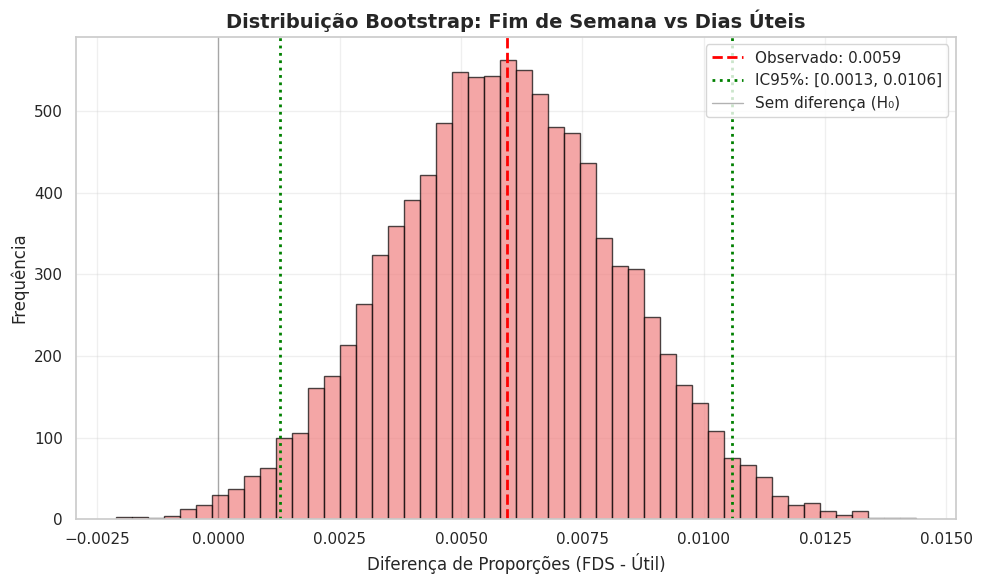


 TÉCNICA UTILIZADA:
   BOOTSTRAP → IC95% da diferença de proporções
   Interpretação: Se IC95% não contém 0, há diferença significativa


In [8]:
print("TESTE 2: Fim de Semana vs Dias Úteis - Bootstrap")
print("="*60)

df_acc = dfs["acidentes"]

if 'fim_semana' not in df_acc.columns:
    df_acc['fim_semana'] = df_acc['dia_semana'].isin(['SABADO', 'DOMINGO'])

df_acc['grave'] = (df_acc['qtde_acid_com_obitos'] > 0).astype(int)

sample_acc = df_acc.sample(frac=0.01, random_state=42)
print(f" Amostra para teste: {len(sample_acc):,} registros (1% do total)")

fds_data = sample_acc[sample_acc['fim_semana'] == True]['grave'].values
util_data = sample_acc[sample_acc['fim_semana'] == False]['grave'].values

prop_fds_obs = np.mean(fds_data)
prop_util_obs = np.mean(util_data)
diff_obs = prop_fds_obs - prop_util_obs

print(f"\n PROPORÇÕES OBSERVADAS:")
print(f"  Fins de semana: {prop_fds_obs:.4f} ({prop_fds_obs*100:.2f}%) - n={len(fds_data):,}")
print(f"  Dias úteis: {prop_util_obs:.4f} ({prop_util_obs*100:.2f}%) - n={len(util_data):,}")
print(f"  Diferença observada: {diff_obs:.4f}")

# ====================================
# BOOTSTRAP para IC95%
# ====================================
n_bootstrap = 10000
bootstrap_diffs = []

print(f"\n Executando {n_bootstrap:,} iterações de Bootstrap...")

np.random.seed(42)
for i in range(n_bootstrap):
    fds_resample = np.random.choice(fds_data, size=len(fds_data), replace=True)
    util_resample = np.random.choice(util_data, size=len(util_data), replace=True)
    diff_boot = np.mean(fds_resample) - np.mean(util_resample)
    bootstrap_diffs.append(diff_boot)

bootstrap_diffs = np.array(bootstrap_diffs)
ic_lower = np.percentile(bootstrap_diffs, 2.5)
ic_upper = np.percentile(bootstrap_diffs, 97.5)

print(f"\n INTERVALO DE CONFIANÇA (BOOTSTRAP):")
print(f"  IC95%: [{ic_lower:.4f}, {ic_upper:.4f}]")

# Interpretação
alpha = 0.05
print(f"\n INTERPRETAÇÃO (α = {alpha}):")
if ic_lower > 0:
    print(f"  IC95% não contém 0 → DIFERENÇA SIGNIFICATIVA")
    print("  Há evidência de que as proporções são diferentes")
    print(f"  Fins de semana têm {((prop_fds_obs-prop_util_obs)/prop_util_obs*100):+.1f}% MAIS acidentes com óbito")
elif ic_upper < 0:
    print(f"  IC95% não contém 0 → DIFERENÇA SIGNIFICATIVA")
    print(f"  Dias úteis têm {((prop_util_obs-prop_fds_obs)/prop_fds_obs*100):+.1f}% MAIS acidentes com óbito")
else:
    print(f"  IC95% contém 0 → Diferença não é estatisticamente significativa")
    print("  Não há evidência conclusiva de diferença entre as proporções")

# Visualização
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(bootstrap_diffs, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax.axvline(diff_obs, color='red', linestyle='--', linewidth=2, label=f'Observado: {diff_obs:.4f}')
ax.axvline(ic_lower, color='green', linestyle=':', linewidth=2, label=f'IC95%: [{ic_lower:.4f}, {ic_upper:.4f}]')
ax.axvline(ic_upper, color='green', linestyle=':', linewidth=2)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3, label='Sem diferença (H₀)')
ax.set_xlabel('Diferença de Proporções (FDS - Útil)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição Bootstrap: Fim de Semana vs Dias Úteis', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n TÉCNICA UTILIZADA:")
print("   BOOTSTRAP → IC95% da diferença de proporções")
print("   Interpretação: Se IC95% não contém 0, há diferença significativa")

## Teste 3: Bootstrap - Faixa Etária vs Gravidade

**H₀:** Faixa etária é independente da ocorrência de óbitos  
**H₁:** Há associação entre faixa etária e gravidade dos acidentes  

**Método:** Bootstrap para estimar IC95% da diferença (focado em Jovens vs Outros grupos)

TESTE 3: Faixa Etária vs Gravidade - Bootstrap
 Usando coluna de idade: faixa_idade_simples
 Amostra para teste: 10,000 registros
 Após limpeza: 10,000 registros válidos

 PROPORÇÕES OBSERVADAS:
  Jovens (18-34): 0.0041 (0.41%) - n=4,099
  Outros grupos: 0.0025 (0.25%) - n=5,901
  Diferença observada: 0.0016

 Executando 10,000 iterações de Bootstrap...

 INTERVALO DE CONFIANÇA (BOOTSTRAP):
  IC95%: [-0.0007, 0.0041]

 INTERPRETAÇÃO (α = 0.05):
  IC95% contém 0 → Diferença não é estatisticamente significativa


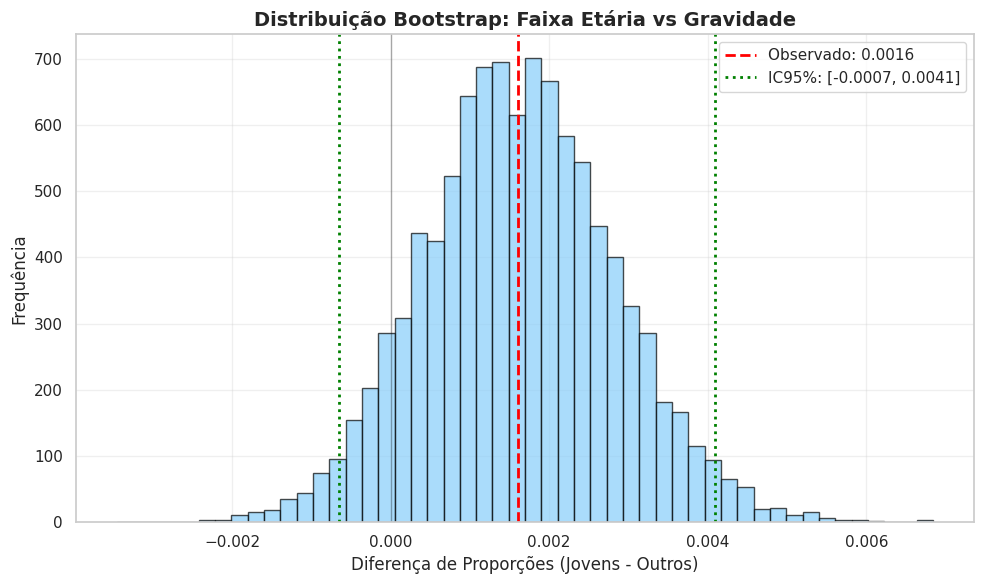


 TÉCNICA UTILIZADA: Bootstrap
   → Compara Jovens (18-34) vs Outros grupos


In [9]:
print("TESTE 3: Faixa Etária vs Gravidade - Bootstrap")
print("="*60)

df_vit = dfs["vitimas"]
df_acc = dfs["acidentes"]

idade_col = 'faixa_idade_simples' if 'faixa_idade_simples' in df_vit.columns else 'faixa_idade'
print(f" Usando coluna de idade: {idade_col}")

df_idade_obitos = df_vit[[idade_col, 'num_acidente']].merge(
    df_acc[['num_acidente', 'qtde_acid_com_obitos']], 
    on='num_acidente', 
    how='left'
)

df_idade_obitos['grave'] = (df_idade_obitos['qtde_acid_com_obitos'] > 0).astype(int)

if len(df_idade_obitos) > 10000:
    df_sample = df_idade_obitos.sample(n=10000, random_state=42)
    print(f" Amostra para teste: {len(df_sample):,} registros")
else:
    df_sample = df_idade_obitos
    print(f" Dataset completo: {len(df_sample):,} registros")

df_clean = df_sample.dropna(subset=[idade_col, 'grave'])
print(f" Após limpeza: {len(df_clean):,} registros válidos")

if len(df_clean) > 100:
    jovens_data = df_clean[df_clean[idade_col] == 'JOVEM (18-34)']['grave'].values
    outros_data = df_clean[df_clean[idade_col] != 'JOVEM (18-34)']['grave'].values
    
    if len(jovens_data) > 30 and len(outros_data) > 30:
        prop_jovens_obs = np.mean(jovens_data)
        prop_outros_obs = np.mean(outros_data)
        diff_obs = prop_jovens_obs - prop_outros_obs
        
        print(f"\n PROPORÇÕES OBSERVADAS:")
        print(f"  Jovens (18-34): {prop_jovens_obs:.4f} ({prop_jovens_obs*100:.2f}%) - n={len(jovens_data):,}")
        print(f"  Outros grupos: {prop_outros_obs:.4f} ({prop_outros_obs*100:.2f}%) - n={len(outros_data):,}")
        print(f"  Diferença observada: {diff_obs:.4f}")
        
        n_bootstrap = 10000
        bootstrap_diffs = []
        
        print(f"\n Executando {n_bootstrap:,} iterações de Bootstrap...")
        
        np.random.seed(42)
        for i in range(n_bootstrap):
            jovens_resample = np.random.choice(jovens_data, size=len(jovens_data), replace=True)
            outros_resample = np.random.choice(outros_data, size=len(outros_data), replace=True)
            diff_boot = np.mean(jovens_resample) - np.mean(outros_resample)
            bootstrap_diffs.append(diff_boot)
        
        bootstrap_diffs = np.array(bootstrap_diffs)
        ic_lower = np.percentile(bootstrap_diffs, 2.5)
        ic_upper = np.percentile(bootstrap_diffs, 97.5)
        
        print(f"\n INTERVALO DE CONFIANÇA (BOOTSTRAP):")
        print(f"  IC95%: [{ic_lower:.4f}, {ic_upper:.4f}]")
        
        alpha = 0.05
        print(f"\n INTERPRETAÇÃO (α = {alpha}):")
        if ic_lower > 0:
            print(f"  IC95% não contém 0 → DIFERENÇA SIGNIFICATIVA")
            print(f"  Jovens (18-34) têm {((prop_jovens_obs-prop_outros_obs)/prop_outros_obs*100):+.1f}% MAIS acidentes graves")
        elif ic_upper < 0:
            print(f"  IC95% não contém 0 → DIFERENÇA SIGNIFICATIVA")
            print(f"  Outros grupos têm {((prop_outros_obs-prop_jovens_obs)/prop_jovens_obs*100):+.1f}% MAIS acidentes graves")
        else:
            print(f"  IC95% contém 0 → Diferença não é estatisticamente significativa")
        
        # Visualização
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        ax.hist(bootstrap_diffs, bins=50, alpha=0.7, color='lightskyblue', edgecolor='black')
        ax.axvline(diff_obs, color='red', linestyle='--', linewidth=2, label=f'Observado: {diff_obs:.4f}')
        ax.axvline(ic_lower, color='green', linestyle=':', linewidth=2, label=f'IC95%: [{ic_lower:.4f}, {ic_upper:.4f}]')
        ax.axvline(ic_upper, color='green', linestyle=':', linewidth=2)
        ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
        ax.set_xlabel('Diferença de Proporções (Jovens - Outros)')
        ax.set_ylabel('Frequência')
        ax.set_title('Distribuição Bootstrap: Faixa Etária vs Gravidade', fontweight='bold', fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\n TÉCNICA UTILIZADA: Bootstrap")
        print("   → Compara Jovens (18-34) vs Outros grupos")
    else:
        print("  Dados insuficientes para jovens ou outros grupos")
else:
    print("  Dados insuficientes para análise estatística")

## Teste 4: Bootstrap - Rodovias Federais vs Outras

**H₀:** A proporção de acidentes com óbito é igual entre rodovias federais e outras rodovias  
**H₁:** As proporções são diferentes  

**Método:** Bootstrap para estimar IC95% da diferença de proporções


 TESTE 4: Rodovias Federais vs Outras - Bootstrap
 Dados com tipo de rodovia válido: 858,992 de 1,673,564 registros
 Amostra inicial: 30,000 registros
 Acidentes em rodovias federais: 1,451
 Acidentes em outras rodovias: 5,000

 PROPORÇÕES OBSERVADAS:
  Rodovias Federais:
    Proporção com óbito: 0.0365 (3.65%)
    Total de óbitos: 58

  Outras Rodovias:
    Proporção com óbito: 0.0214 (2.14%)
    Total de óbitos: 119

  Diferença de proporções observada: 0.0151

 Executando 10,000 iterações de Bootstrap...

 RESULTADOS DO BOOTSTRAP:
  Diferença de proporções:
    Observada: 0.0151
    IC95%: [0.0051, 0.0257]

 INTERPRETAÇÃO (α = 0.05):
  IC95% não contém 0 → DIFERENÇA SIGNIFICATIVA
  Rodovias FEDERAIS têm +70.7% MAIS acidentes com óbito


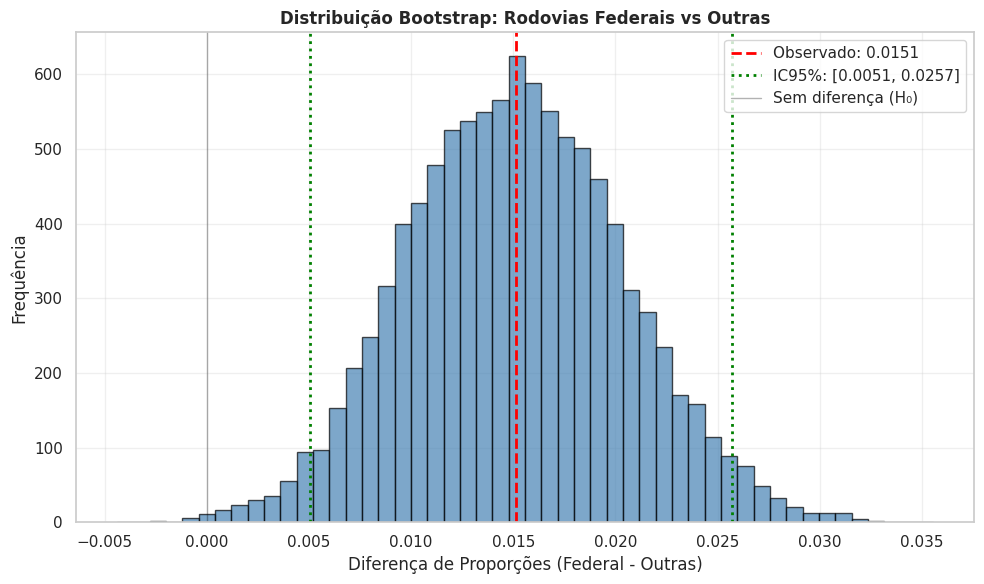


 TÉCNICA UTILIZADA: Bootstrap
   → Foco em proporções
   → Otimizado: Amostra inicial 30k + 10000 iterações


In [10]:
print(" TESTE 4: Rodovias Federais vs Outras - Bootstrap")
print("="*65)

df_acc = dfs["acidentes"]

missing_patterns = ['NAO INFORMADO', 'NÃO INFORMADO', 'DESCONHECIDO', 
                   'SEM INFORMACAO', 'SEM INFORMAÇÃO', 'IGNORADO']

mask_rodovia_valida = ~df_acc['tp_rodovia'].astype(str).str.upper().isin(missing_patterns)
df_acc_clean = df_acc[mask_rodovia_valida]

print(f" Dados com tipo de rodovia válido: {len(df_acc_clean):,} de {len(df_acc):,} registros")

sample_size = 30000
if len(df_acc_clean) > sample_size:
    df_acc_sample = df_acc_clean.sample(n=sample_size, random_state=42)
    print(f" Amostra inicial: {len(df_acc_sample):,} registros")
else:
    df_acc_sample = df_acc_clean
    print(f" Dataset completo: {len(df_acc_sample):,} registros")

def categorize_rodovia(tp_rodovia):
    if pd.isna(tp_rodovia):
        return 'OUTROS'
    tp_str = str(tp_rodovia).upper()
    if 'FEDERAL' in tp_str:
        return 'FEDERAL'
    else:
        return 'OUTRAS'

df_acc_sample = df_acc_sample.copy()
df_acc_sample['tp_rodovia_simples'] = df_acc_sample['tp_rodovia'].apply(categorize_rodovia)
df_acc_sample['tem_obito'] = (df_acc_sample['qtde_obitos'] > 0).astype(int)

federais = df_acc_sample[df_acc_sample['tp_rodovia_simples'] == 'FEDERAL']
outras = df_acc_sample[df_acc_sample['tp_rodovia_simples'] == 'OUTRAS']

if len(federais) > 5000:
    federais = federais.sample(n=5000, random_state=42)
if len(outras) > 5000:
    outras = outras.sample(n=5000, random_state=42)

print(f" Acidentes em rodovias federais: {len(federais):,}")
print(f" Acidentes em outras rodovias: {len(outras):,}")

if len(federais) > 30 and len(outras) > 30:

    group_federal = federais['tem_obito'].values
    group_outras = outras['tem_obito'].values
    
    prop_fed_obs = np.mean(group_federal)
    prop_out_obs = np.mean(group_outras)
    diff_obs = prop_fed_obs - prop_out_obs

    print(f"\n PROPORÇÕES OBSERVADAS:")
    print(f"  Rodovias Federais:")
    print(f"    Proporção com óbito: {prop_fed_obs:.4f} ({prop_fed_obs*100:.2f}%)")
    print(f"    Total de óbitos: {np.sum(federais['qtde_obitos']):,}")
    
    print(f"\n  Outras Rodovias:")
    print(f"    Proporção com óbito: {prop_out_obs:.4f} ({prop_out_obs*100:.2f}%)")
    print(f"    Total de óbitos: {np.sum(outras['qtde_obitos']):,}")
    
    print(f"\n  Diferença de proporções observada: {diff_obs:.4f}")

    n_bootstrap = 10000
    bootstrap_diffs = []
    
    print(f"\n Executando {n_bootstrap:,} iterações de Bootstrap...")
    
    np.random.seed(42)
    for i in range(n_bootstrap):
        fed_resample = np.random.choice(group_federal, size=len(group_federal), replace=True)
        out_resample = np.random.choice(group_outras, size=len(group_outras), replace=True)
        diff_boot = np.mean(fed_resample) - np.mean(out_resample)
        bootstrap_diffs.append(diff_boot)
    
    bootstrap_diffs = np.array(bootstrap_diffs)
    ic_lower = np.percentile(bootstrap_diffs, 2.5)
    ic_upper = np.percentile(bootstrap_diffs, 97.5)
    
    print(f"\n RESULTADOS DO BOOTSTRAP:")
    print(f"  Diferença de proporções:")
    print(f"    Observada: {diff_obs:.4f}")
    print(f"    IC95%: [{ic_lower:.4f}, {ic_upper:.4f}]")
    
    alpha = 0.05
    print(f"\n INTERPRETAÇÃO (α = {alpha}):")
    if ic_lower > 0:
        print(f"  IC95% não contém 0 → DIFERENÇA SIGNIFICATIVA")
        print(f"  Rodovias FEDERAIS têm {((prop_fed_obs-prop_out_obs)/prop_out_obs*100):+.1f}% MAIS acidentes com óbito")
    elif ic_upper < 0:
        print(f"  IC95% não contém 0 → DIFERENÇA SIGNIFICATIVA")
        print(f"  Outras rodovias têm {((prop_out_obs-prop_fed_obs)/prop_fed_obs*100):+.1f}% MAIS acidentes com óbito")
    else:
        print(f"  IC95% contém 0 → Diferença não é estatisticamente significativa")
        print("  Não há evidência conclusiva de diferença entre as proporções")
    
    # Visualização
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    ax.hist(bootstrap_diffs, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(diff_obs, color='red', linestyle='--', linewidth=2, label=f'Observado: {diff_obs:.4f}')
    ax.axvline(ic_lower, color='green', linestyle=':', linewidth=2, label=f'IC95%: [{ic_lower:.4f}, {ic_upper:.4f}]')
    ax.axvline(ic_upper, color='green', linestyle=':', linewidth=2)
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3, label='Sem diferença (H₀)')
    ax.set_xlabel('Diferença de Proporções (Federal - Outras)')
    ax.set_ylabel('Frequência')
    ax.set_title('Distribuição Bootstrap: Rodovias Federais vs Outras', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n TÉCNICA UTILIZADA: Bootstrap")
    print("   → Foco em proporções")
    print("   → Otimizado: Amostra inicial 30k + 10000 iterações")
else:
    print("  Dados insuficientes para teste estatístico confiável")
